In [10]:
# Import libraries
import torch
from torch import optim
from torch.utils.data import DataLoader, Subset
import torch.nn.functional as F

# A module to print a model summary (outputs shape, number of parameters, ...)
import torchsummary

# TensorBoard for visualization
from torch.utils.tensorboard import SummaryWriter

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})
from sklearn.model_selection import train_test_split
from PIL import Image
from datetime import datetime

from pathlib import Path

# Custom modules and packages
import params.siamese
import traversalcost.utils
from dataset import SiameseNetworkDataset
from model import SiameseNetwork
from loss import SiameseLoss
from train import train
from validate import validate
from test import test
from result import parameters_table, generate_log

from params import PROJECT_PATH

## Load learning parameters

In [11]:
LEARNING_PARAMS = params.siamese.LEARNING

## Prepare data

In [12]:
# Create a Dataset for training
train_set = SiameseNetworkDataset(
    pairs_file=params.siamese.DATASET / "pairs_train.csv",
    features_directory=params.siamese.DATASET / "features",
)

# Create a Dataset for validation
# (same as training here since no transformation is applied to the data,
# train and validation sets will be split later)
val_set = SiameseNetworkDataset(
    pairs_file=params.siamese.DATASET / "pairs_train.csv",
    features_directory=params.siamese.DATASET / "features",
)

# Create a Dataset for testing
test_set = SiameseNetworkDataset(
    pairs_file=params.siamese.DATASET / "pairs_test.csv",
    features_directory=params.siamese.DATASET / "features",
)

# Set the train dataset size
train_size = params.siamese.TRAIN_SIZE/(1-params.siamese.TEST_SIZE)

# Splits train data indices into train and validation data indices
train_indices, val_indices = train_test_split(range(len(train_set)),
                                              train_size=train_size)

# Extract the corresponding subsets of the train dataset
train_set = Subset(train_set, train_indices)
val_set = Subset(val_set, val_indices)


# Combine a dataset and a sampler, and provide an iterable over the dataset
# (setting shuffle argument to True calls a RandomSampler, and avoids to
# have to create a Sampler object)
train_loader = DataLoader(
    train_set,
    batch_size=LEARNING_PARAMS["batch_size"],
    shuffle=True,
    num_workers=12,  # Asynchronous data loading and augmentation
    pin_memory=True,  # Increase the transferring speed of the data to the GPU
)

val_loader = DataLoader(
    val_set,
    batch_size=LEARNING_PARAMS["batch_size"],
    shuffle=True,
    num_workers=12,
    pin_memory=True,
)

test_loader = DataLoader(
    test_set,
    batch_size=LEARNING_PARAMS["batch_size"],
    shuffle=False,  # SequentialSampler
    num_workers=12,
    pin_memory=True,
)

In [13]:
# Get the number of samples per split
NB_TRAIN = len(train_set)
NB_VAL = len(val_set)
NB_TEST = len(test_set)

In [14]:
# Display the splits ratio
NB_SAMPLES = NB_TRAIN + NB_VAL + NB_TEST

print(f"{np.round(NB_TRAIN/NB_SAMPLES*100)} % of the data for training ({NB_TRAIN} samples)")
print(f"{np.round(NB_VAL/NB_SAMPLES*100)} % of the data for validation ({NB_VAL} samples)")
print(f"{np.round(NB_TEST/NB_SAMPLES*100)} % of the data for testing ({NB_TEST} samples)")

70.0 % of the data for training (67736 samples)
15.0 % of the data for validation (14516 samples)
15.0 % of the data for testing (14516 samples)


## GPU?

In [15]:
# Use a GPU if available
# device = "cpu"
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}\n")

Device: cuda



## Training and validation

In [16]:
# Create a model
nb_input_features = len(train_set[0][0])
model = SiameseNetwork(input_size=nb_input_features).to(device=device)

#Visualize the model
print(model)

SiameseNetwork(
  (mlp): Sequential(
    (0): Linear(in_features=78, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=32, bias=True)
    (7): ReLU()
    (8): Linear(in_features=32, out_features=1, bias=True)
    (9): ReLU()
  )
)


In [17]:
# Create a loss function
criterion = SiameseLoss(margin=LEARNING_PARAMS["margin"]).to(device=device)

In [18]:
# Define the optimizer
optimizer = optim.SGD(model.parameters(),
                      lr=LEARNING_PARAMS["learning_rate"],
                      momentum=LEARNING_PARAMS["momentum"],
                      weight_decay=LEARNING_PARAMS["weight_decay"])

# Create tensors to store the loss values
loss_values = torch.zeros(2, LEARNING_PARAMS["nb_epochs"])

# Create tensors to store the accuracy values
accuracy_values = torch.zeros(2, LEARNING_PARAMS["nb_epochs"])

# Loop over the epochs
for epoch in range(LEARNING_PARAMS["nb_epochs"]):
    
    # Training
    train_loss, train_accuracy = train(model,
                                       device,
                                       train_loader,
                                       optimizer,
                                       criterion,
                                       epoch)
    
    # Validation
    val_loss, val_accuracy = validate(model,
                                      device,
                                      val_loader,
                                      criterion,
                                      epoch) 
    
    print("Train loss: ", train_loss)
    print("Validation loss: ", val_loss)
    print("Train accuracy: ", train_accuracy)
    print("Validation accuracy: ", val_accuracy)
    
    # Store the computed losses
    loss_values[0, epoch] = train_loss
    loss_values[1, epoch] = val_loss
    
    # Store the computed accuracies
    accuracy_values[0, epoch] = train_accuracy
    accuracy_values[1, epoch] = val_accuracy

  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.23714729417484812
Validation loss:  0.21387931802987
Train accuracy:  74.07139482697532
Validation accuracy:  76.73601543124828


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.20276008917122545
Validation loss:  0.19714835670157152
Train accuracy:  77.83453407346167
Validation accuracy:  78.59603196472858


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.18561983553163278
Validation loss:  0.17821101594864008
Train accuracy:  79.80689736624542
Validation accuracy:  80.83494075502894


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.16932116732409364
Validation loss:  0.1564060796856355
Train accuracy:  81.7910712176686
Validation accuracy:  83.60429870487738


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.15716678748387453
Validation loss:  0.15492980812352133
Train accuracy:  83.26296208810676
Validation accuracy:  83.7420777073574


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.13965954555231969
Validation loss:  0.13184337437743657
Train accuracy:  85.36524152592418
Validation accuracy:  86.42187930559383


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.1239586385411964
Validation loss:  0.12977208408818372
Train accuracy:  87.23426243061297
Validation accuracy:  86.50454670708184


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.11161474753399858
Validation loss:  0.1107280232537423
Train accuracy:  88.50980276367072
Validation accuracy:  88.62634334527418


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.10047543169341355
Validation loss:  0.11751150164244459
Train accuracy:  89.83110901145625
Validation accuracy:  88.14411683659411


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.09155018778906553
Validation loss:  0.09630491490996881
Train accuracy:  90.83057753631746
Validation accuracy:  90.19013502342243


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.08297856938449193
Validation loss:  0.0823387119114924
Train accuracy:  91.66765087988662
Validation accuracy:  91.8297051529347


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.07303814990472354
Validation loss:  0.08133433035488696
Train accuracy:  92.72026691862526
Validation accuracy:  91.98815100578672


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.07018305154823337
Validation loss:  0.06672478072131914
Train accuracy:  93.14839966930435
Validation accuracy:  93.52438688343896


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.061832618463443234
Validation loss:  0.06791508581801133
Train accuracy:  94.00761781032243
Validation accuracy:  93.26260677872692


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.056677859893017664
Validation loss:  0.045519317711584496
Train accuracy:  94.54056926892642
Validation accuracy:  95.65307247175531


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.04739409167323054
Validation loss:  0.058053344697383796
Train accuracy:  95.37173733317586
Validation accuracy:  94.4130614494351


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.04758459478493594
Validation loss:  0.04368838575557859
Train accuracy:  95.35845045470651
Validation accuracy:  95.5841829705153


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.043925865544085375
Validation loss:  0.058045865026290326
Train accuracy:  95.75262784929727
Validation accuracy:  94.23394874621108


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.0432488773892281
Validation loss:  0.02971512239656128
Train accuracy:  95.72310145269871
Validation accuracy:  97.25130890052355


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.036744550601302224
Validation loss:  0.027894726821061405
Train accuracy:  96.4199244124247
Validation accuracy:  97.29264260126757


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.03693710288518338
Validation loss:  0.02379698703057309
Train accuracy:  96.41549545293492
Validation accuracy:  97.90575916230367


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.031828306293039385
Validation loss:  0.03120278475584569
Train accuracy:  96.95435219085863
Validation accuracy:  97.02397354643152


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.033567498496542766
Validation loss:  0.022969011953798028
Train accuracy:  96.78309909058699
Validation accuracy:  97.81620281069165


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.029188858405832022
Validation loss:  0.024672667811817536
Train accuracy:  97.19499232313689
Validation accuracy:  97.76109120969964


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.02872434646600015
Validation loss:  0.022279076936699876
Train accuracy:  97.31162158970119
Validation accuracy:  97.83686966106366


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.02775457609977795
Validation loss:  0.03833062964848485
Train accuracy:  97.3012873508917
Validation accuracy:  96.36952328465142


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.02734553166889393
Validation loss:  0.017354376698200003
Train accuracy:  97.35000590527932
Validation accuracy:  98.44998622209975


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.02352363228792636
Validation loss:  0.02962855047788389
Train accuracy:  97.76042281799928
Validation accuracy:  97.18241939928355


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.022775539828902347
Validation loss:  0.02298796901454747
Train accuracy:  97.80028345340735
Validation accuracy:  97.91264811242766


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.022621493646303392
Validation loss:  0.021261066272198367
Train accuracy:  97.85343096728475
Validation accuracy:  97.95398181317167


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.021429228901553538
Validation loss:  0.02362770878910887
Train accuracy:  97.93167591827094
Validation accuracy:  97.80931386056766


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.020375572109807765
Validation loss:  0.01603411392017477
Train accuracy:  98.06602102279437
Validation accuracy:  98.49820887296777


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.018408756407647903
Validation loss:  0.02205998537495798
Train accuracy:  98.24465572221565
Validation accuracy:  97.87131441168366


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.017724286424078757
Validation loss:  0.03287022079583175
Train accuracy:  98.33323491201133
Validation accuracy:  97.10664094791953


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.018979246273893614
Validation loss:  0.03984393485070982
Train accuracy:  98.24465572221565
Validation accuracy:  96.23174428217139


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.020573924653534623
Validation loss:  0.021226990974143083
Train accuracy:  98.06159206330459
Validation accuracy:  97.87131441168366


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.015321417912406403
Validation loss:  0.017001527778000163
Train accuracy:  98.54582496752096
Validation accuracy:  98.44309727197574


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.015243530093592866
Validation loss:  0.015067112088482416
Train accuracy:  98.60192512105823
Validation accuracy:  98.6704326260678


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.017022627078672137
Validation loss:  0.02136703241526227
Train accuracy:  98.4262430612968
Validation accuracy:  98.0917608156517


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.01593387270358596
Validation loss:  0.02076584276730925
Train accuracy:  98.52072753041219
Validation accuracy:  98.09864976577569


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.017066476258033283
Validation loss:  0.012368018989192757
Train accuracy:  98.39524034486831
Validation accuracy:  98.90465693028382


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.015152556396056956
Validation loss:  0.009186438619187881
Train accuracy:  98.62554623833708
Validation accuracy:  99.21465968586388


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.013045678093740971
Validation loss:  0.013293858395996073
Train accuracy:  98.77317822132987
Validation accuracy:  98.61532102507577


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.01692601362580998
Validation loss:  0.012954029002296636
Train accuracy:  98.38638242588874
Validation accuracy:  98.87021217966382


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.014172503116564355
Validation loss:  0.01041315757517707
Train accuracy:  98.64621471595606
Validation accuracy:  99.13199228437585


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.013515125635599786
Validation loss:  0.013633704206820101
Train accuracy:  98.72298334711232
Validation accuracy:  98.7875447781758


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.010615359249544999
Validation loss:  0.014687176740478052
Train accuracy:  99.01529467343805
Validation accuracy:  98.60154312482777


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.013477338031655472
Validation loss:  0.027997519866058744
Train accuracy:  98.71412542813275
Validation accuracy:  97.4648663543676


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.013442712896648615
Validation loss:  0.010732562036052478
Train accuracy:  98.75398606354081
Validation accuracy:  99.06999173325985


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.012525124164919058
Validation loss:  0.010180074551310965
Train accuracy:  98.86175741112555
Validation accuracy:  99.06999173325985


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.013537168018238458
Validation loss:  0.015045595010701518
Train accuracy:  98.74955710405102
Validation accuracy:  98.55332047395977


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.011247020983862726
Validation loss:  0.009620874233970558
Train accuracy:  98.97838667768985
Validation accuracy:  99.18021493524387


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.010044235518911012
Validation loss:  0.009440457007318473
Train accuracy:  99.0758237864651
Validation accuracy:  99.03554698263984


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.010473541487131454
Validation loss:  0.007701978374617216
Train accuracy:  99.01086571394826
Validation accuracy:  99.24221548635988


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.011642620280979517
Validation loss:  0.02344510341186224
Train accuracy:  98.97543403803
Validation accuracy:  97.85753651143565


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.010438440502572864
Validation loss:  0.0201288870215777
Train accuracy:  99.08025274595488
Validation accuracy:  98.02287131441169


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.010091329864685786
Validation loss:  0.014019927325851328
Train accuracy:  99.0389157907169
Validation accuracy:  98.64287682557179


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.009599992432442474
Validation loss:  0.010428773360285859
Train accuracy:  99.11125546238337
Validation accuracy:  99.06999173325985


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.009461384544516645
Validation loss:  0.01676274308245547
Train accuracy:  99.12158970119286
Validation accuracy:  98.40865252135575


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.010141200627392903
Validation loss:  0.012792099082620922
Train accuracy:  99.05220266918626
Validation accuracy:  98.7668779278038


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.008198050499785555
Validation loss:  0.006848564537627713
Train accuracy:  99.2603637652061
Validation accuracy:  99.3317718379719


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.010541917662539918
Validation loss:  0.016925138203911318
Train accuracy:  99.04925002952639
Validation accuracy:  98.45687517222375


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.01089494326701555
Validation loss:  0.007580451308318828
Train accuracy:  99.0020077949687
Validation accuracy:  99.31799393772388


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.01066080238089683
Validation loss:  0.012921448862631416
Train accuracy:  99.01972363292784
Validation accuracy:  98.79443372829981


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.010670843476128814
Validation loss:  0.005220968662945775
Train accuracy:  99.04039211054683
Validation accuracy:  99.60044089280794


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.009155348936189054
Validation loss:  0.013881196897673843
Train accuracy:  99.17178457541041
Validation accuracy:  98.70487737668779


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.009069483639273134
Validation loss:  0.022487355984895107
Train accuracy:  99.18950041336956
Validation accuracy:  97.89198126205567


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.010035990651193883
Validation loss:  0.0064929195511511766
Train accuracy:  99.07434746663517
Validation accuracy:  99.4075502893359


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.007601945986399626
Validation loss:  0.0054014540946168525
Train accuracy:  99.32679815755286
Validation accuracy:  99.55221824193993


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.007153898532079345
Validation loss:  0.009479491446282108
Train accuracy:  99.35780087398133
Validation accuracy:  99.06999173325985


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.008024258226221314
Validation loss:  0.00784457752497514
Train accuracy:  99.28841384197473
Validation accuracy:  99.3317718379719


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.009127524233316761
Validation loss:  0.01057057329227877
Train accuracy:  99.18211881421992
Validation accuracy:  99.06310278313585


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.0072238752187508476
Validation loss:  0.010042462551285254
Train accuracy:  99.36222983347112
Validation accuracy:  99.13888123449986


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.008717264801112547
Validation loss:  0.010061900484240265
Train accuracy:  99.22788472894769
Validation accuracy:  99.14577018462386


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.005480032067700194
Validation loss:  0.007094669955811312
Train accuracy:  99.51133813629384
Validation accuracy:  99.3731055387159


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.005044907215381141
Validation loss:  0.0051086304918555175
Train accuracy:  99.55710405102161
Validation accuracy:  99.57977404243593


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.007325862999126047
Validation loss:  0.01025194915971567
Train accuracy:  99.35927719381127
Validation accuracy:  99.02176908239184


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.008831049725888218
Validation loss:  0.003562958387961603
Train accuracy:  99.18950041336956
Validation accuracy:  99.68999724441996


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.008620137190912359
Validation loss:  0.007428763609683133
Train accuracy:  99.24707688673675
Validation accuracy:  99.3799944888399


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.006511633784788976
Validation loss:  0.004115531108206721
Train accuracy:  99.43309318530767
Validation accuracy:  99.67621934417195


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.006063327548112562
Validation loss:  0.004657701964568068
Train accuracy:  99.4508090232668
Validation accuracy:  99.56599614218793


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.007948892494457809
Validation loss:  0.007507409119655713
Train accuracy:  99.27955592299516
Validation accuracy:  99.25599338660788


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.005456787506795582
Validation loss:  0.008033945557501348
Train accuracy:  99.53053029408291
Validation accuracy:  99.25599338660788


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.006817520858158865
Validation loss:  0.009045246842887565
Train accuracy:  99.38880359040982
Validation accuracy:  99.11132543400386


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.007529633313178228
Validation loss:  0.005795098137569979
Train accuracy:  99.32532183772292
Validation accuracy:  99.4488839900799


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.007558342215813507
Validation loss:  0.00386219752115497
Train accuracy:  99.3076059997638
Validation accuracy:  99.65555249379995


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.006063734282800141
Validation loss:  0.009655125324290229
Train accuracy:  99.487717019015
Validation accuracy:  99.09065858363185


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.006667228305678924
Validation loss:  0.009245220274307523
Train accuracy:  99.3976615093894
Validation accuracy:  99.26288233673188


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.00966457886018063
Validation loss:  0.0046468520868315245
Train accuracy:  99.19540569268926
Validation accuracy:  99.59355194268393


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.005438345676592293
Validation loss:  0.006749881261196562
Train accuracy:  99.51871973544348
Validation accuracy:  99.3731055387159


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.004495947133675851
Validation loss:  0.01880574250790713
Train accuracy:  99.61615684421874
Validation accuracy:  98.34665197023973


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.008353222271021213
Validation loss:  0.011956092311245788
Train accuracy:  99.2603637652061
Validation accuracy:  98.89087903003582


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.0055859379010403405
Validation loss:  0.0032885229074763388
Train accuracy:  99.5246250147632
Validation accuracy:  99.75888674565996


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.004371015563417258
Validation loss:  0.0058480906484870135
Train accuracy:  99.62353844336837
Validation accuracy:  99.46266189032791


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.005536561383319644
Validation loss:  0.005508935099492252
Train accuracy:  99.52167237510334
Validation accuracy:  99.48332874069992


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.006626752577634129
Validation loss:  0.007016147946372694
Train accuracy:  99.40504310853903
Validation accuracy:  99.3593276384679


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.004970462532402689
Validation loss:  0.010977344359743044
Train accuracy:  99.56596197000118
Validation accuracy:  98.96665748139984


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.005603389237146399
Validation loss:  0.0039145395688975175
Train accuracy:  99.5142907759537
Validation accuracy:  99.68999724441996


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.006748280126946196
Validation loss:  0.004496988637315413
Train accuracy:  99.40061414904925
Validation accuracy:  99.64866354367594


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.004102066788924427
Validation loss:  0.009671661373030903
Train accuracy:  99.651588520137
Validation accuracy:  99.11132543400386


### Visualization

Text(0.5, 0, 'Epoch')

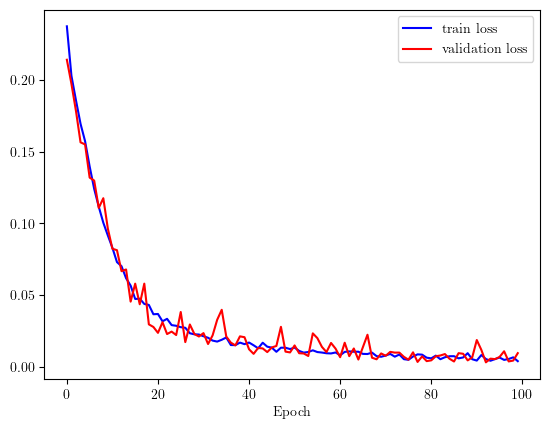

In [19]:
# Loss
train_losses = loss_values[0]
val_losses = loss_values[1]

figure = plt.figure()

plt.plot(train_losses, "b", label="train loss")
plt.plot(val_losses, "r", label="validation loss")

plt.legend()
plt.xlabel("Epoch")

Text(0.5, 0, 'Epoch')

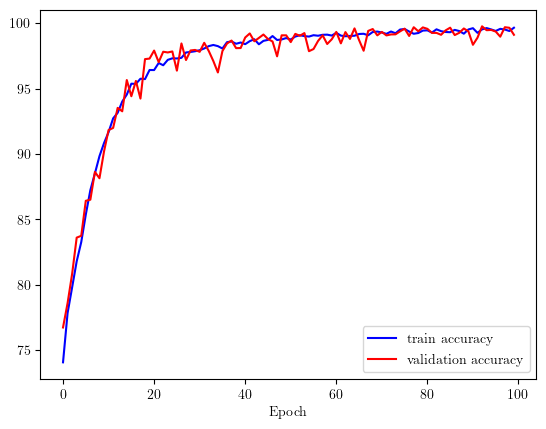

In [20]:
# Accuracy
train_accuracies = accuracy_values[0]
val_accuracies = accuracy_values[1]

plt.plot(train_accuracies, "b", label="train accuracy")
plt.plot(val_accuracies, "r", label="validation accuracy")

plt.legend()
plt.xlabel("Epoch")

## Testing

In [21]:
# Test the model
test_loss, test_accuracy = test(model,
                                device,
                                test_loader,
                                criterion)

print("Test loss: ", test_loss)
print("Test accuracy: ", test_accuracy)

Test loss:  0.00851713082576704
Test accuracy:  99.18021493524387


## Compute and display traversal costs

In [22]:
# Compute the traversal costs from the features of the dataset
costs_df = traversalcost.utils.compute_traversal_costs(
    dataset=params.siamese.DATASET,
    cost_function=model.to(device="cpu"),
    to_tensor=True
)

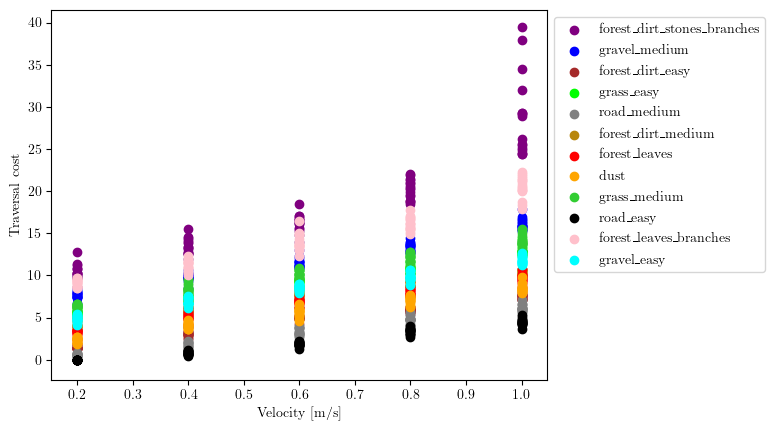

In [24]:
# Display the traversal costs
cost_graph = traversalcost.utils.display_traversal_costs(costs_df)

## Generate a log directory

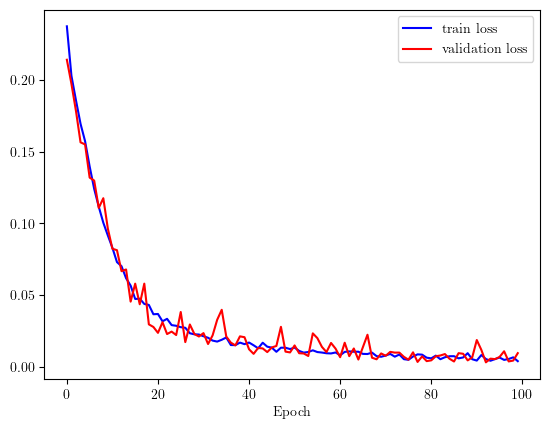

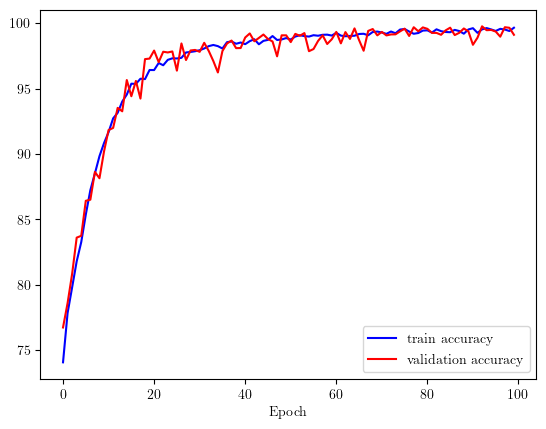

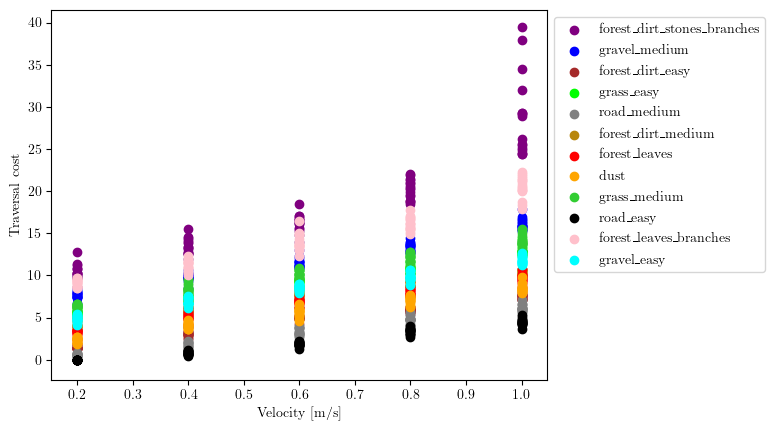

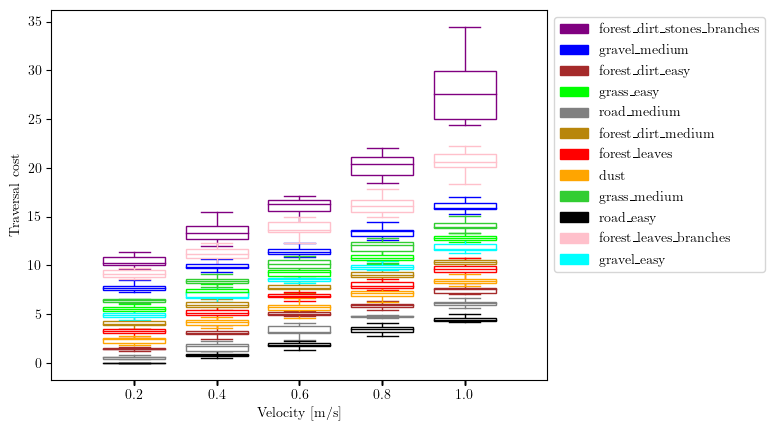

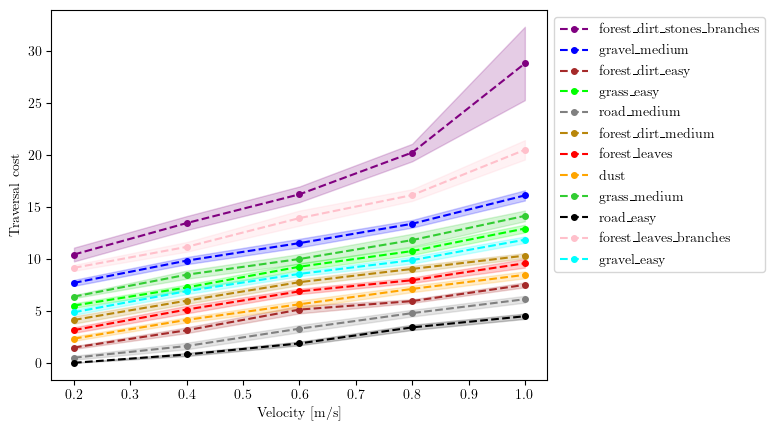

In [40]:
# Get the learning parameters table
params_table = parameters_table(dataset=params.siamese.DATASET,
                                learning_params=LEARNING_PARAMS)

# Set the path to the results directory
if params.siamese.LOG_DIR:
    results_directory = Path(
        "logs/_" +
        params.siamese.LOG_DIR
    )
else:
    results_directory = Path(
        "logs/_" +
        datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
    )
                        
# Generate the log directory
generate_log(dataset_directory=params.siamese.DATASET,
             results_directory=results_directory,
             test_loss=test_loss,
             test_accuracy=test_accuracy,
             parameters_table=params_table,
             model=model,
             loss_values=loss_values,
             accuracy_values=accuracy_values)
costs_df.to_csv(results_directory / "costs_df.csv", sep=',', encoding='utf-8')
np.save(results_directory / "mean", costs_df['cost'].mean())

In [41]:
results_directory = PROJECT_PATH / "src/traversal_cost/siamese_network/logs/_2023-09-19-15-37-35"

costs_df = pd.read_csv(results_directory / "costs_df.csv", sep=',', encoding='utf-8')
df_filtered = costs_df[costs_df['linear_velocity'] == 1.0]
df_filtered.groupby(['terrain_class']).mean()


,Unnamed: 0,linear_velocity,cost
terrain_class,,,
dust,311.5,1.0,8.465829
forest_dirt_easy,391.5,1.0,7.503398
forest_dirt_medium,791.5,1.0,10.314275
forest_dirt_stones_branches,551.5,1.0,28.817385
forest_leaves,951.5,1.0,9.580561
forest_leaves_branches,631.5,1.0,20.500881
grass_easy,71.5,1.0,12.924111
grass_medium,471.5,1.0,14.142108
gravel_easy,151.5,1.0,11.848593
